In [1]:
using Plots
using LaTeXStrings
using FilePathsBase
using Dates
using Statistics

In [2]:
include("src/constants.jl")
include("src/main.jl")
include("src/solver_code.jl")
include("src/piecewise_polytrope_eos_cgs.jl")
using .MainModule
using .SolverCode
using .PiecePoly
# Typical scale
println("length scale: ", unit_l, " cm")
println("energy density scale: ", ε_ref, " g/cm^3")
println("energy density scale: ", ε_ref*gcm3_to_MeVfm3/1000, " GeV/fm^3")

length scale: 147661.32831248126 cm
energy density scale: 6.175945314552516e17 g/cm^3
energy density scale: 346.44512454233296 GeV/fm^3


In [3]:
println("Original parameters: ", PiecePoly.fixed_ρ_bounds)
PiecePoly.fixed_ρ_bounds = [4.28800e+14, 8.55829e+14]
println("Changed parameters: ", PiecePoly.fixed_ρ_bounds)

Original parameters: [5.0118723362727144e14, 1.0e15]
Changed parameters: [4.288e14, 8.55829e14]


In [4]:
println("Original parameters: ", PiecePoly.fixed_crust[end])

Original parameters: ("crust4", nothing, 1.35692, 3.99874e-8)


In [46]:
K1 = 3.50290e-5
ρ_lower_bound = 4.28800E+14 
γ = 2.64258
log10P1 = log10(K1*ρ_lower_bound^γ)

rho_lim_all, a_all, K_all, Gamma_all = PiecePoly.get_all_params(log10P1, [2.64258, 3.5, 1.45303])
ε_temp, p_temp = PiecePoly.make_polyEos(rho_lim_all, a_all, K_all, Gamma_all)
ε, p = MainModule.make_eos_monotonic(ε_temp, p_temp)
println(log10P1, ", ", Gamma_all)
# rho_lim_all[4] = 1.02148e+14
println(rho_lim_all.*gcm3_to_MeVfm3)
println(rho_lim_all[4].*gcm3_to_MeVfm3 - 1.02148E+14*gcm3_to_MeVfm3)

34.21133156712513, [1.58425, 1.28733, 0.62223, 1.35692, 2.64258, 3.5, 1.45303]
[1.3689303453408157e-5, 0.2122432724958245, 1.474087693307734, 57.30394160128756, 240.5391593311349, 480.08486052053604, Inf]
0.00311593114584241


In [39]:
# ファイルパスを指定
file_path = "data/eos_HQC18_gv100H160.txt"
P = []
e = []
cs2 = [] 
# ファイルを行単位で読み込む
lines = readlines(file_path)
println(lines[1])
for line in lines[2:end]
    # 行をスペースで分割して各値を数値に変換
    values = parse.(Float64, split(line))
    push!(P, values[2]) 
    push!(e, values[4]) 
    push!(cs2, values[5].^2) 
end

file_path2 = "data/eos_HQC18_gv080H150.txt"
P2 = []
e2 = []
lines = readlines(file_path2)
for line in lines[2:end]
    values = parse.(Float64, split(line))
    push!(P2, values[2]) 
    push!(e2, values[4])
end

file_path3 = "data/eos_HQC18_gv050H140.txt"
P3 = []
e3 = []
lines = readlines(file_path3)
for line in lines[2:end]
    values = parse.(Float64, split(line))
    push!(P3, values[2]) 
    push!(e3, values[4])
end

 muB (MeV)    P (MeV/fm^3)           nB/n0    e (MeV/fm^3)              cs


386
[1.3689303453408157e-5, 0.2122432724958245, 1.474087693307734, 57.30394160128756, 240.5391593311349, 480.08486052053604, Inf]


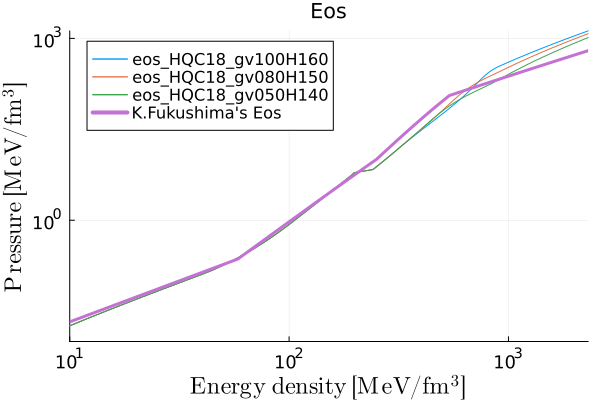

In [40]:
mono_e, mono_P = MainModule.make_eos_monotonic(e, P)
mono_e2, mono_P2 = MainModule.make_eos_monotonic(e2, P2)
mono_e3, mono_P3 = MainModule.make_eos_monotonic(e3, P3)

println(length(mono_e))
# グラフの描画
plot(mono_e, mono_P;
    label="eos_HQC18_gv100H160", 
    xlabel=L"\mathrm{Energy\ density\ [MeV/fm^3]}",xlabelfontsize=16,
    ylabel=L"\mathrm{Pressure\ [MeV/fm^3]}", ylabelfontsize=16,
    title="Eos",
    legend=:topleft,
    xscale=:log10,  # x軸を対数スケールに変更
    yscale=:log10,  # y軸を対数スケールに変更)
    xtickfontsize=12,
    ytickfontsize=12,
    xlims=(10,mono_e[end]), ylims=(1e-2, mono_P[end]),
)
plot!(mono_e2, mono_P2; label=splitext(basename(file_path2))[1])
plot!(mono_e3, mono_P3; label=splitext(basename(file_path3))[1])

plot!(ε.*gcm3_to_MeVfm3, p.*gcm3_to_MeVfm3;
    label="K.Fukushima's Eos",
    lw=3
)
println(rho_lim_all.*gcm3_to_MeVfm3)
# 凡例のフォントサイズを変更
plot!(legendfontsize=11)  # 凡例のフォントサイズを指定
# savefig("three_types_QHC18_eos.pdf")  # PDFファイルとして保存

In [55]:
start_time = now()
RMT, sol = MainModule.out_RMT(mono_e*MeVfm3_to_gcm3/ε_ref, mono_P*MeVfm3_to_gcm3/ε_ref, debug=false)
RMT2, sol2 = MainModule.out_RMT(mono_e2*MeVfm3_to_gcm3/ε_ref, mono_P2*MeVfm3_to_gcm3/ε_ref)
RMT3, sol3 = MainModule.out_RMT(mono_e3*MeVfm3_to_gcm3/ε_ref, mono_P3*MeVfm3_to_gcm3/ε_ref)
RMT4, sol4 = MainModule.out_RMT(ε/ε_ref, p/ε_ref; max_pc=2.5e-3)
end_time = now()
elapsed_ms = Dates.value(end_time - start_time)  # ミリ秒で取得
elapsed_sec = elapsed_ms / 4000  # 秒に変換
println(elapsed_sec, " sec/RMT")

22.42525 sec/RMT


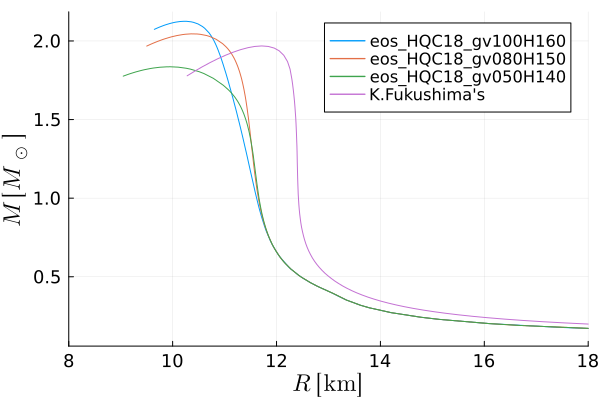

In [56]:
plot(RMT[1], RMT[2]; 
    label=splitext(basename(file_path))[1],
    legend=:topright,
    xlabel=L"R\ [\mathrm{km}]", xlabelfontsize=16,
    ylabel=L"M\ [M_\odot]", ylabelfontsize=16,
    xlims=(8,18),
    xtickfontsize=12,
    ytickfontsize=12,
)
plot!(RMT2[1], RMT2[2]; label=splitext(basename(file_path2))[1])
plot!(RMT3[1], RMT3[2]; label=splitext(basename(file_path3))[1])
plot!(RMT4[1], RMT4[2]; label="K.Fukushima's")
# 凡例のフォントサイズを変更
plot!(legendfontsize=11)  # 凡例のフォントサイズを指定
# savefig("three_types_QHC18_MR.pdf")  # PDFファイルとして保存